# Adversarial Example

### 0610
offset 변경

## Configuration

In [1]:
import warnings

warnings.filterwarnings(action='ignore')

import torch

### local imports
import model


### Environment imports
import click # Class object() 대신 argument 조절 library 사용
import math
import os
import shutil # 고수준 파일 연산
import torch
import torch.utils.data.dataset
import torchvision

In [6]:
### Configuration settings
# Resnet의 기본 학습 단계이다. 
# Training rate / size parameters
TRAIN_BATCHSIZE = 128  # GPU 개수에 따라 배수로 조절해도 됨.
TRAIN_LR = 0.1  # GPU 개수에 따라 배수로 조절해도 됨. --> ?
TRAIN_MOMENTUM = 0.9 #  --> (SGD optimizer 사용)
TRAIN_WEIGHT_DECAY = 1e-4 # --> (SGD optimizer 사용)
TRAIN_EPOCHS = [170, 195, 200]  # Divide lr by 10 at each; finish after last. --> 해당 epoch이 될 때마다 학습률을 0.1배


In [7]:
# Adversarial training settings
# 적대적 훈련은 노이즈에 대한 L2 loss를 최소화함
# 동시에 번갈아가면서 class에서 멀어지도록 gradient ascent를 진행..
TRAIN_ADV_EPS = 0.01 # 적대적 설명을 사용한다.
TRAIN_ADV_L2MIN_EPS = 0.1 # 적대적 설명을 사용할 때 L2 MIN도 사용가능.

#### 추가적 이해 필요

In [ ]:
# 적대적 설명에 대한 예시
"""Trains a network and saves the result at PATH.

    Options:

        --adversarial-training: Train the network using adversarial examples.
                By default, the adversarial examples are generated using a
                standard "L_2" loss function and an epsilon of 0.01.

        --l2-min: Only valid with --adversarial-training.  If specified, use
                the "L_{2,min}"  method of generating adversarial examples,
                with an epsilon of 0.1. # 적대적 학습의 L2 min. 

        --robust-additions: Train with the best settings of the other
                modifications in the paper, including: defense via Lipschitz
                Continuity with "L_{adv,z=2}", "\zeta = 0.2" using
                "L_{adv,tandem}", the Half-Huber ReLU, no output zeroing,
                an adaptive "\psi" with "L_{target}=1.5", "k_{\psi,0}=220",
                "k_{\psi}=\ln 0.02", "\epsilon_{better}=1",
                "\epsilon_{worse}=0.01", and half-half adversarial training when
                also using adversarial training.
"""

In [ ]:
# Adversarial robustness parameters
ROBUST_Z = 2
ROBUST_ZETA = 0.2  # 항상 쌍으로 이루어진다(tandem).
ROBUST_ADAPT_L_TARGET = 1.5
ROBUST_ADAPT_PSI_0 = 220
ROBUST_ADAPT_PSI = 0.02
ROBUST_ADAPT_EPS_POS = 1
ROBUST_ADAPT_EPS_NEG = 0.01

In [1]:
# Offset as [mean, std] of data input. --> ( Resnet 메인 모델의 forward, 정규화)
MODEL_INPUT_OFFSET = [[0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]]

### 네트워크 구조

In [2]:
def cifar10_preprocess(ft_out):
    return torch.nn.Conv2d(3, ft_out, kernel_size=3, padding=1, bias=False)

In [ ]:
MODEL_ARCH=[
    32, # input size, 정사각형 가정
    cifar10_preprocess, #Resnet의 initial layer.
    [(44 - 2)//6 for _ in range(3)],# [7,7,7],  Block Length --> ( ... ) 
    [16, 32, 64], # feature의 개수들.
    10,  # class 개수 (cifar-10)
]

In [ ]:
# Low-resource computer를 위한 실험 (우선 배제)
# ONE_BATCH_ONLY = False


## dataset

### automobile

In [2]:
#save_path='../BDD100K_MOT2020_image/bdd100k/images/track/new_train' 0609


root='../BDD100K_MOT2020_image/bdd100k/images/track/train_av'
root_test='../BDD100K_MOT2020_image/bdd100k/images/track/test_av'

label_save_path='../BDD100K_MOT2020_label/bdd100k/labels/box_track_20/new_train'

#### 기존

In [3]:
def _get_dataset():
    
    
    """Returns (ds_train, ds_test) with augmentations on training set.
    """
    T = torchvision.transforms
#     aug_pad = 4
#     aug_dim = 32 + aug_pad * 2
    transform_train = T.Compose([T.ToTensor(), ])
        
    ds_train = torchvision.datasets.ImageFolder(root, 
            transform=T.ToTensor())
    ds_test = torchvision.datasets.ImageFolder(root_test, 
            transform=T.ToTensor())
    
    return ds_train, ds_test

In [ ]:
ds_train, ds_test=get

#### 변경

In [556]:
ds_test.classes

['bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'trailer',
 'train',
 'truck']

증강사용

In [528]:
def _get_dataset2():
    """Returns (ds_train, ds_test) with augmentations on training set.
    """
    T = torchvision.transforms
    aug_pad = 4
    aug_dim = 32 + aug_pad * 2
    ds_train = torchvision.datasets.ImageFolder(root, 
            transform=T.Compose([
                T.ToTensor(),
                T.Lambda(lambda tensor:
                    torch.nn.functional.pad(
                        tensor.view(1, 3, 32, 32),
                        (aug_pad,)*4,
                        'replicate').view(3, aug_dim, aug_dim)),
                T.ToPILImage(),
                T.RandomHorizontalFlip(),
                T.RandomCrop((32, 32)),
                T.ToTensor(),
            ]))
    ds_test = torchvision.datasets.ImageFolder(root_test,
            transform=torchvision.transforms.ToTensor())
    return ds_train, ds_test

### Train, Test Image Folder

In [355]:
labels=os.listdir(root)
for label in labels:
    print(label, len(os.listdir(os.path.join(root,label))))

trailer 305
motorcycle 983
bicycle 3505
car 57212
bus 7549
other vehicle 2699
pedestrian 44011
other person 422
truck 15033
train 3
rider 1919


In [4]:
labels=os.listdir(root)
for label in labels:
    print(label, len(os.listdir(os.path.join(root,label))))

trailer 990
motorcycle 8114
bicycle 19637
car 102971
bus 40409
other vehicle 13644
pedestrian 104779
other person 1974
truck 99964
train 1064
rider 13336


> root_test는 추후에 밸런스 맞춰서 할당.

In [58]:
labels=os.listdir(root_test)
for label in labels:
    print(len(os.listdir(os.path.join(root_test,label))))

51
176
1086
14257
981
469
9427
130
4520
1
397


22:06

In [116]:
ds_train, ds_test=_get_dataset()

In [117]:
ds_test

Dataset ImageFolder
    Number of datapoints: 31495
    Root location: ../BDD100K_MOT2020_image/bdd100k/images/track/test_av
    StandardTransform
Transform: ToTensor()

In [356]:
ds_train.class_to_idx

{'bicycle': 0,
 'bus': 1,
 'car': 2,
 'motorcycle': 3,
 'other person': 4,
 'other vehicle': 5,
 'pedestrian': 6,
 'rider': 7,
 'trailer': 8,
 'train': 9,
 'truck': 10}

In [367]:
i=0

1


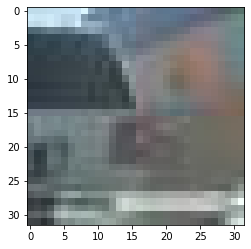

In [385]:
print(ds_train[i][1])
img=ds_train[i][0].numpy()
img=np.swapaxes(img,0,1)
img=np.swapaxes(img,1,2)
plt.imshow(img)
i+=500

### 셔플 잘 되나.

In [444]:
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=128,
            shuffle=True, num_workers=8, drop_last=False)

In [459]:
batch=next(iter(train_loader))

In [463]:
batch[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
batch[0[0]]

In [481]:
i=0

In [484]:
ds_train.class_to_idx

{'bicycle': 0,
 'bus': 1,
 'car': 2,
 'motorcycle': 3,
 'other person': 4,
 'other vehicle': 5,
 'pedestrian': 6,
 'rider': 7,
 'trailer': 8,
 'train': 9,
 'truck': 10}

tensor(1)


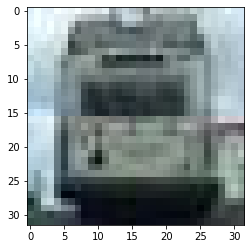

In [524]:
print(batch[1][i])
img=batch[0][i].numpy()
img=np.swapaxes(img,0,1)
img=np.swapaxes(img,1,2)
plt.imshow(img)
i+=1

셔플은 잘 된듯.

#### 데이터증강 사용

In [529]:
ds_train, ds_test=_get_dataset2()

In [530]:
ds_train

Dataset ImageFolder
    Number of datapoints: 133641
    Root location: ../BDD100K_MOT2020_image/bdd100k/images/track/train_av
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
               ToPILImage()
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=None)
               ToTensor()
           )

In [531]:
i=0

1


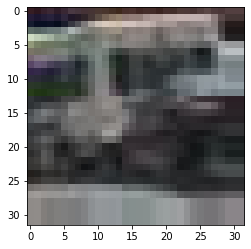

In [550]:
print(ds_train[i][1])
img=ds_train[i][0].numpy()
img=np.swapaxes(img,0,1)
img=np.swapaxes(img,1,2)
plt.imshow(img)
i+=500

In [159]:
def get_dataset_cifar():
    """Returns (ds_train, ds_test) with augmentations on training set.
    """
    T = torchvision.transforms
    aug_pad = 4
    aug_dim = 32 + aug_pad * 2
    ds_train = torchvision.datasets.CIFAR10('CIFAR10_PATH', train=True,
            transform=T.Compose([
                T.ToTensor(),
                T.Lambda(lambda tensor:
                    torch.nn.functional.pad(
                        tensor.view(1, 3, 32, 32),
                        (aug_pad,)*4,
                        'replicate').view(3, aug_dim, aug_dim)),
                T.ToPILImage(),
                T.RandomHorizontalFlip(),
                T.RandomCrop((32, 32)),
                T.ToTensor(),
            ]))
    ds_test = torchvision.datasets.CIFAR10('CIFAR10_PATH', train=False,
            transform=torchvision.transforms.ToTensor())
    return ds_train, ds_test

In [102]:
import numpy as np
import matplotlib.pyplot as plt

In [99]:
train[0][0].numpy().shape

(3, 32, 32)

In [389]:
train.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [390]:
i=0

4


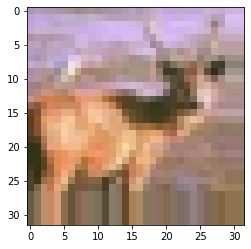

In [409]:
print(train[i][1])
img=train[i][0].numpy()
img=np.swapaxes(img,0,1)
img=np.swapaxes(img,1,2)
plt.imshow(img)
i+=500

In [73]:
train, test=get_dataset_cifar()

### cifar-10

#### 우선 환경변수 부분은 건들지 않도록 해보자.

In [ ]:
# # # CIFAR-10 찾기
# # # CIFAR10_PATH에 관한 환경변수가 없다면 None을 반환한다.
# # cifar10_path = os.environ.get('CIFAR10_PATH', '')

# if not cifar10_path.strip():
# #     raise ValueError('Must specify CIFAR10_PATH environment variable.')

In [3]:
# cifar10_path='CIFAR10_PATH/'

# # 경로설정
# if not os.path.exists(cifar10_path):
#     os.mkdir(cifar10_path)
# # dataset 다운로드
# if len(os.listdir(cifar10_path))==0:
#     torchvision.datasets.CIFAR10(cifar10_path, download=True)

# Labels
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
#         'frog', 'horse', 'ship', 'truck']

## 커맨드라인 함수

In [18]:
@click.group()
def main():
    """Resnet-44 network를 학습하고, 설명하는 함수"""
    

    
# 특정 path에 대해 Attack and BTR ARAs(Accuracy-Robustness Area)를 구하는 함수 
@main.command()
@click.argument('path') # argument와 option의 차이점 -->(option은 특성을 더 가진다) )
@click.option('--n-images', default=1000, type=int) # --를 붙히는 이유 (option이라? 아마 약속)
@click.option('--eps', default=20, type=float) # (... )에 대한 epsilon
@click.option('--steps', default=450, type=int) # (... )에 대한 steps
@click.option('--momentum', default=0.9, type=float)
def calculate_ara(path, n_images, eps, steps, momentum):
    """Calculates the Attack and BTR Accuracy-Robustness Areas (ARAs) for
    PATH.

    Options:

        --n-images: Number of images to use for the ARA calculation.  Defaults
                to 1000.

        --eps: Maximum perturbation to apply.  May be greater than 1; per
                Algorithm 1, many of the steps taken will minimize the
                perturbation magnitude instead of decreasing confidence in the
                correct class.  Defaults to 450*.1*.5 = 20, which is about what
                the paper used.

        --steps: Number of steps to use in determining the lowest-magnitude
                perturbation which results in a change of either accuracy or
                BTR, based on the ARA being calculated.  Defaults to 450.

        --momentum: If using fewer than 100 ``steps``, probably best to disable
                momentum by setting it to zero.  Defaults to 0.9.

    """
    # Set up model
    m = _model_load(path)

    device = torch.device('cpu')
    if torch.cuda.device_count() > 0:
        device = torch.device('cuda')
        m = m.to(device)
        m = torch.nn.DataParallel(m)

    m.eval()

    # Set up dataset based on first --n-images of random test-set permutation
    ds_train, ds_test = _get_dataset()
    state = torch.get_rng_state()
    torch.manual_seed(1776)
    idx_all = [int(i) for i in torch.randperm(len(ds_test))]
    torch.set_rng_state(state)
    ds_test = torch.utils.data.dataset.Subset(ds_test, idx_all[:n_images])

    for ara_name, ara_type in [('Attack', True), ('BTR', 'btr')]:
        batch_size = TRAIN_BATCHSIZE * max(1, torch.cuda.device_count())
        test_loader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size,
                shuffle=False, num_workers=8, drop_last=False)

        n = 0
        diffs = []
        for batch in test_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            n += images.size(0)

            advs = _adv_images(m, images, labels, AdversarialOptions(
                    steps=steps, eps=eps, eps_overshoot=1, use_l2min=ara_type,
                    momentum=momentum))
            mags = advs.sub_(images).pow_(2).mean((1, 2, 3)).sqrt_()
            diffs.extend(mags.tolist())
            print('.', end='', flush=True)
        print('')
        assert n == n_images
        assert n == len(diffs)

        # Convert from perturbations to percentages
        naive_guess = 1. / m.module.training_options['arch'][-1]
        diffs = torch.Tensor(diffs)
        bins = 1000
        diff_max = diffs.max().item()
        hist = diffs.histc(bins, min=0, max=diff_max)
        gap = diff_max / bins
        ara = gap * (1 - hist.cumsum(0) / n_images).add_(-naive_guess).clamp_(min=0).sum()
        print(f'{ara_name} ARA: {ara}')



### 설명 함수

In [19]:
torch.cuda.device_count()

8

In [21]:
@main.command() # main은 여전히 위에서 정의한 main 함수이다. 
@click.argument('path')
@click.option('--eps', default=0.1) # (...)에 대한 epsilon
def explain(path, eps):
    """CIFAR-10 dataset의 첫 10개 test example에 대한 설명
    
    output/에 우선적으로 저장한다."""
    
    output_dir='output'
    
    # output 폴더 내 하위 폴더, 파일을 모두 삭제 (굳이 os 말고 이걸 쓰는 이유는? 깔끔한 삭제일 듯)
    try:
        shutil.rmtree(output_dir)
    except FileNotFoundError:
        pass
    
    ds_train, ds_test=_get_dataset() # 아래에서 정의, tensor 형태로 저장
    m= _model_load(path) # static, 아래에서 정의. 
    
    # Determine cuda status
    
    device=torch.device('cpu') # 우선 cpu 설정
    if torch.cuda.device_count() > 0: # gpu 이용 가능할 시 (cuda 잡혀있음)
        device = torch.device('cuda') 
        m=m.to(device) # 모델을 device로 보내준다.
        # small-bath explanations에 대해 Multi-GPU는 더 느리다.
        #m=torch.nn.DataParallel(m)
    
    # Explanation 생성
    
    m.eval() # 추론 실행 전에 드롭 아웃 및 배치 정규화를 평가 모드로 설정해야 한다. 
    
    for i in range(10): #1개
        img, label = ds_test[i]
      """
      이는 논문 외 적인 코드이므로 이후에 작성.
      
      
      
      
      
      """
    
        
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 35)

### Adversarial 학습

In [22]:
@main.command()
@click.argument('path')
@click.option('--adversarial-training/--no-adversarial-training', default=False)
@click.option('--l2-min/--no-l2-min', default=False)
@click.option('--robust-additions/--no-robust-additions', default=False)
def train(path, **training_options):
    """Trains a network and saves the result at PATH.

    Options:

        --adversarial-training: Train the network using adversarial examples.
                By default, the adversarial examples are generated using a
                standard "L_2" loss function and an epsilon of 0.01.

        --l2-min: Only valid with --adversarial-training.  If specified, use
                the "L_{2,min}"  method of generating adversarial examples,
                with an epsilon of 0.1. #적대적 학습의 L2 min. 

        --robust-additions: Train with the best settings of the other
                modifications in the paper, including: defense via Lipschitz
                Continuity with "L_{adv,z=2}", "\zeta = 0.2" using
                "L_{adv,tandem}", the Half-Huber ReLU, no output zeroing,
                an adaptive "\psi" with "L_{target}=1.5", "k_{\psi,0}=220",
                "k_{\psi}=\ln 0.02", "\epsilon_{better}=1",
                "\epsilon_{worse}=0.01", and half-half adversarial training when
                also using adversarial training.
    """
    ds_train, ds_test = _get_dataset()
    training_options['arch'] = MODEL_ARCH # 모델 구조
    training_options['input_offset'] = MODEL_INPUT_OFFSET # data input의 평균, 분산 차이
    m = model.Model(training_options) # model.MODEL : RESNET model.

    # GPU의 개수를 정하고, 이에 따라 batch size와 learn rate을 설정하자.
    g = max(torch.cuda.device_count(), 1)
    batch_size = TRAIN_BATCHSIZE * g
    opt = torch.optim.SGD(m.parameters(), lr=TRAIN_LR * g,
            momentum=TRAIN_MOMENTUM, weight_decay=TRAIN_WEIGHT_DECAY)
    # 이유는 솔직히 잘 모르겠다. ( ... ) 
    
    # Move to GPU (필요하다면)
    device = torch.device('cpu')
    m_orig = m  # Preserve original reference for saving
    if torch.cuda.device_count() > 0:
        device = torch.device('cuda')
        m = m.to(device)
        m = torch.nn.DataParallel(m)

    # 훈련 Loop.
    # ds_train은 dataset의 transform을 통해 Tensor로 바뀐 형태이다. 
    # train은 augmentation을 위한 패딩, RandomFlip, RandomCrop 등이 적용됐다.
    train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
            shuffle=True, num_workers=8, drop_last=False)
    test_loader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size,
            shuffle=False, num_workers=8, drop_last=False)
    # num_workers = ( ... )
    for epoch in range(max(TRAIN_EPOCHS)):
        print(f'== {epoch} ==')
        # Update learning rate
        lr = TRAIN_LR * g # gpu개수
        
        for e in TRAIN_EPOCHS: # epoch이 진행될수록 학습률 낮추기. 
            if epoch >= e:
                lr *= 0.1
        for pg in opt.param_groups: # optimizer 학습률 반영
            pg['lr'] = lr

        #  training on batch
        m.train() # m.eval()과 비슷한 선언. (...)
        n = 0
        loss = 0.
        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            n += images.size(0)

            if training_options['adversarial_training']:
                adv_opts = AdversarialOptions(
                        use_l2min=training_options['l2_min'],
                        eps=0.1 if training_options['l2_min'] else 0.01,
                        use_half_and_half=training_options['robust_additions'],
                        ensure_proper_minimization=False,
                )
                
                ##############################메인
                
                images = _adv_images(m, images, labels, adv_opts) 
                
                ########################################
            stats = _model_train_batch(m, training_options, opt, images,
                    labels)
            loss += stats['class_loss_sum']
            if ONE_BATCH_ONLY:
                break
        print(f'Loss: {loss / n:.4f}')
        if training_options['robust_additions']:
            print(f'Psi: {_model_robust_get_psi(training_options["robust_integration"]):.1f}')

        _model_save(path, m_orig, training_options)

    # test 실행.
    stats = _model_evaluate(m, test_loader)
    print("Testing statistics:")
    for k, v in stats.items():
        print(f'{k}: {v}')



### 적대적이미지 생성

In [23]:
class AdversarialOptions:
    encourage_labels = False  # True for explanations
    eps = 0.1 #(...)
    eps_overshoot = 1.  # Multiplier for step size; if > 1, uses g_explain (...)
    momentum = 0  # Momentum for generating the explanations; with a large
                  # step count, this is useful.  Otherwise not very useful.
    steps = 7
    use_half_and_half = False
    use_l2min = False
    ensure_proper_minimization = True
    # For explanations and ARA calculations, ensure_proper_minimization serves
    # as a sanity check.  Basically, it checks that an adversarial example
    # satisfying the criteria is found prior to half the number of optimization
    # steps taken, ensuring that some number of the remaining steps are used
    # for minimizing the perturbation.
    
     # 설명이나 ARA 계산을 위해서 enusre_proper_minimization은 sanity check 역할.
    # 기본적으로, 이는 기준을 만족하는 adversarial example이 optimization steps의 절반 이전에서
    # 발견되는 지를 체크하고, 이는 남은 steps이 perturbation을 minimizing하는 데 쓰이는 걸 확인한다.
    # 오류방지.
    def __init__(self, **kw):
        for k, v in kw.items():
            if not hasattr(AdversarialOptions, k):
                raise ValueError(k)
            setattr(self, k, v)


In [24]:
training_options={'adversarial_training':True, 'l2_min':True, 'robust_additions':True}
training_options['arch']=MODEL_ARCH
training_options['input_offset']=MODEL_INPUT_OFFSET


In [25]:
adv_opts=AdversarialOptions(
                        use_l2min=training_options['l2_min'],
                        eps=0.1 if training_options['l2_min'] else 0.01,
                        use_half_and_half=training_options['robust_additions'],
                        ensure_proper_minimization=False,
                )

In [26]:
ds_train, ds_test = _get_dataset()


In [27]:
m=model.Model(training_options)
g=1
batch_size=TRAIN_BATCHSIZE*g
opt=torch.optim.SGD(m.parameters(), lr=TRAIN_LR*g, momentum=TRAIN_MOMENTUM, weight_decay=TRAIN_WEIGHT_DECAY)


In [28]:
device=torch.device('cpu')
m_orig=m
if torch.cuda.device_count()>0:
    device=torch.device('cuda')
    m=m.to(device)
    m=torch.nn.DataParallel(m)
    

In [29]:
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
            shuffle=True, num_workers=8, drop_last=False)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size,
        shuffle=False, num_workers=8, drop_last=False)

In [30]:
print(type(train_loader))

torch.utils.data.dataloader.DataLoader


In [32]:
n=0
loss=0


In [33]:
test_batch=next(iter(train_loader))

In [34]:
images, labels =test_batch # batchsize는 128인데 images의 size는 80인 이유? 128*390 + 80 = 50000. 즉, 남는 80개부터 배치(확인완료)
images = images.to(device)
labels = labels.to(device)

In [35]:
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [36]:
n += images.size(0)

#### 메인

In [37]:
# for     images = _adv_images(m, images, labels, adv_opts)

In [38]:
# opts : adv_opts

In [39]:
help(adv_opts)

Help on AdversarialOptions in module __main__ object:

class AdversarialOptions(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, **kw)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  encourage_labels = False
 |  
 |  ensure_proper_minimization = True
 |  
 |  eps = 0.1
 |  
 |  eps_overshoot = 1.0
 |  
 |  momentum = 0
 |  
 |  steps = 7
 |  
 |  use_half_and_half = False
 |  
 |  use_l2min = False



In [40]:
images=images.detach()
deltas=images.new_zeros(images.size()).requires_grad_()

In [41]:
if adv_opts.use_half_and_half:
    affected=torch.rand(images.size(0), 1, 1, 1, device=images.device)
    affected=(affected<0.5).float()
else:
    affected=torch.ones(images.size(0), 1, 1, 1, device=images.device)

In [42]:
target_labels=labels
target_encourage=False


In [43]:
adv_opts.eps

0.1

In [44]:
size=adv_opts.eps*adv_opts.eps_overshoot
print(size)

0.1


In [45]:
mom=images.new_zeros(images.size()) # moment?( .., )

In [46]:
adv_opts.use_l2min

True

In [47]:
track_best=True if adv_opts.use_l2min else False
extra_steps=1 if track_best else 0 

In [48]:
if track_best:
    # Also track the first step at which results were OK, and the
    # lowest-perturbation delta.
    best_ok_deltas = torch.zeros_like(images) # 이미지 텐서와 같은 0 tensor 
    # batch size의 0 tensor.. 
    best_ok_deltas_sqr = images.new_zeros(images.size(0)).fill_(1e30) # size로 

In [50]:
deltas

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [51]:
guesses=m(images+deltas)

In [52]:
print(guesses.size())

torch.Size([128, 10])


In [53]:
guesses[0]

tensor([ 3.0266e-01,  4.9181e-01,  6.8617e-03,  4.8616e-03,  1.3202e-01,
         1.0858e+00,  1.0398e-01,  9.8926e-01,  3.3431e-01, -1.0808e-03],
       device='cuda:0', grad_fn=<SelectBackward>)

In [54]:
torch.nn.functional.softmax(guesses[0])

tensor([0.0885, 0.1069, 0.0658, 0.0657, 0.0746, 0.1936, 0.0725, 0.1758, 0.0913,
        0.0653], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [55]:
guesses[0]

tensor([ 3.0266e-01,  4.9181e-01,  6.8617e-03,  4.8616e-03,  1.3202e-01,
         1.0858e+00,  1.0398e-01,  9.8926e-01,  3.3431e-01, -1.0808e-03],
       device='cuda:0', grad_fn=<SelectBackward>)

In [56]:
target_labels

tensor([1, 4, 9, 5, 6, 5, 0, 3, 2, 1, 5, 8, 8, 9, 3, 5, 0, 9, 2, 0, 4, 8, 3, 4,
        3, 0, 6, 4, 5, 2, 3, 5, 4, 2, 3, 1, 6, 3, 1, 6, 7, 7, 8, 1, 4, 2, 8, 3,
        6, 1, 9, 9, 0, 1, 0, 8, 1, 3, 3, 3, 0, 9, 7, 3, 3, 7, 3, 1, 4, 3, 8, 7,
        7, 2, 0, 2, 6, 6, 4, 6, 9, 9, 7, 8, 0, 7, 7, 5, 6, 5, 3, 1, 6, 7, 4, 2,
        7, 3, 6, 2, 6, 2, 4, 7, 6, 9, 4, 7, 1, 7, 5, 9, 7, 8, 8, 2, 4, 2, 1, 9,
        2, 9, 3, 2, 4, 7, 7, 6], device='cuda:0')

In [57]:
loss = torch.nn.functional.cross_entropy(guesses, target_labels,
                reduction='none')

In [58]:
image_grads=torch.autograd.grad(loss.sum(), deltas, retain_graph=True)

In [59]:
image_grads=image_grads[0]

In [60]:
if isinstance(adv_opts.use_l2min, str):
    if adv_opts.use_l2min == 'btr':
        sm = guesses.softmax(1)
        follow_loss = (sm.gather(1, target_labels.unsqueeze(1))[:, 0]
                > 1/sm.size(1)).float()
    else:
        raise NotImplementedError(adv_opts.use_l2min)
        
elif adv_opts.use_l2min:
            # l2_min; aim to be correct
            follow_loss = (guesses.argmax(1) == target_labels).float()
else:
    # Standard l2; aim to be within eps.
    follow_loss = (deltas.detach().pow(2).mean((1, 2, 3))
            < adv_opts.eps ** 2).float()


In [61]:
# 예측이 맞은 친구들. 후에 (... )
follow_loss

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.], device='cuda:0')

In [68]:
if track_best: # l2min 사용할 때.
    # Track the best perturbation which satisfies the criteria.
    ddist = deltas.detach().pow(2).mean((1, 2, 3)) # noise의 L2 mean. (channel, w, h)
    
    # uncorrect sample  +  noise(delta)가 의 l2 mean이 best 일 때. 즉, 작을 때.
    set_best = (follow_loss == 0) * (ddist < best_ok_deltas_sqr) # 예측을 못한 경우
    
    # 예측도 틀리고, L2 mean도 작은 delta들만 best deltas로 보낸다. 
    best_ok_deltas[set_best] = deltas.detach()[set_best]
    best_ok_deltas_sqr[set_best] = ddist[set_best]

SyntaxError: 'break' outside loop (<ipython-input-67-b7e2bbeb5996>, line 19)

In [72]:
target_encourage

False

In [75]:
size*(adv_opts.steps-step)

0.7000000000000001

In [79]:
ss=size*(adv_opts.steps -step) / (adv_opts.steps*(adv_opts.steps+1)/2)

In [87]:
follow_loss=follow_loss.view(-1,1,1,1)

In [90]:
-deltas.detach()

tensor([[[[-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          ...,
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.]],

         [[-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          ...,
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.]],

         [[-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          ...,
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.]]],


        [[[-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0.

In [91]:
1-follow_loss

tensor([[[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],




In [89]:
sdir=follow_loss*image_grads+(1-follow_loss)*-deltas.detach()

tensor([[[[-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
          [ 0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000, -0.0000],
          [-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000, -0.0000]],

         [[-0.0000,  0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000],
          [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000]],

         [[-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000, -0.0000],
          [-0.0000,  0.0000, -

In [119]:
sdir = (
                follow_loss * image_grads
                + (1 - follow_loss) * -deltas.detach())

In [157]:
guesses.max()

tensor(1.8031, device='cuda:0', grad_fn=<MaxBackward1>)

In [160]:
torch.nn.functional.cross_entropy(guesses, target_labels, reduction='none')

tensor([2.2359, 2.3612, 2.3073, 2.0079, 2.2287, 2.1392, 2.3744, 2.6745, 2.3502,
        2.0370, 2.0248, 2.5069, 2.5007, 3.6208, 2.2783, 2.1875, 2.0193, 2.6752,
        3.0164, 2.2428, 2.7278, 2.4528, 3.0654, 2.6148, 2.8551, 2.7972, 2.2589,
        2.2446, 2.0398, 4.0249, 2.5222, 2.1833, 2.4737, 2.4336, 2.5988, 2.1357,
        2.4553, 2.6813, 2.0680, 2.5388, 1.9658, 2.0778, 2.4983, 2.2687, 2.5078,
        3.0193, 2.4752, 2.6348, 2.4686, 2.0236, 2.6285, 2.6880, 2.1875, 2.2762,
        2.0067, 2.6311, 2.1178, 2.4885, 2.9132, 2.2765, 1.9918, 2.6611, 2.0264,
        3.0685, 2.6208, 2.2330, 2.6871, 1.9551, 2.2948, 3.0446, 2.6085, 2.0972,
        2.1306, 2.6930, 2.1192, 2.4014, 2.2955, 2.3346, 2.6664, 2.1023, 2.7488,
        2.6142, 1.9777, 2.2870, 2.2871, 2.1731, 1.9677, 2.2774, 2.0741, 2.1110,
        3.0453, 2.0682, 2.6141, 2.1982, 2.4420, 2.4664, 2.1319, 2.5967, 2.3989,
        3.1402, 2.2477, 2.8931, 2.5287, 2.0738, 2.2899, 2.3590, 2.4865, 2.0801,
        2.5266, 2.0636, 1.8821, 2.5005, 

In [ ]:
# images, labels : gpu에 tensor단위로 할당된 상태
# 아래 함수는 하나의 batch 내에서 실행

def _adv_images(m, images, labels, opts):
    if opts.steps <= 0:
        return images

    images = images.detach() # 복사. images.data()와 동일하나 오류 측면 처리에서 선호, 
    deltas = images.new_zeros(images.size()).requires_grad_() # gradient 자동 추적, 하고싶지 않을 시 detach. --> 학습용
    
    # affected : [batch_size, 1, 1, 1] 크기의 binary tensor
    # affected : ( ... ) 의 역할
    if opts.use_half_and_half: # batch가 절반의 adversarial, 절반의 original로 구성
        # 배치 사이즈 만큼의 tensor를 random으로 생성해 약 절반을 0으로 조정
        affected = torch.rand(images.size(0), 1, 1, 1, device=images.device)
        affected = (affected < 0.5).float()
    else:
        affected = torch.ones(images.size(0), 1, 1, 1, device=images.device)
    
    target_labels = labels
    
    
    
    # 설명을 위해서는 True로 설정, 아마 학습에는 False
    target_encourage = False 
    if opts.encourage_labels:
        if isinstance(target_labels, list): # 혹시 label이 list형태일 경우
            target_labels = torch.LongTensor(target_labels).to(images.device) # LongTensor는 정수형으로 나타난다.
        target_encourage = True
        
        # l2min이랑 labels에대한 설명은 동시에 할 수 없다. (왜? ...) 학습이라? 
        assert not opts.use_l2min, 'Cannot combine l2_min with encourage_labels'
    
    # size는 ( step size에 곱해지는 데)에 적용. (더 민감하게 이동) =0.1 
    size = opts.eps * opts.eps_overshoot # 0.1 (eps)* 1 ( # Multiplier for step size; if > 1, uses g_explain)
    mom = images.new_zeros(images.size()) # momemntum, (step size가 클 때. )
    
    # l2min을 사용할 때 track_best = True, extra_steps =1
    track_best = True if opts.use_l2min else False
    extra_steps = 1 if track_best else 0
    
    # ARA 계산 또는 Explanation에 해당한다면 (...) Explanation 할 때.
    if opts.ensure_proper_minimization: 
        first_ok_steps = images.new_zeros(images.size(0),
                dtype=torch.int).fill_(999 + opts.steps)
    
    # l2min을 사용할 때
    if track_best:
        # Also track the first step at which results were OK, and the lowest-perturbation delta.
        # 결과가 양호했던 first step과 lowest-perturbation delta를 추적합니다.
        # (noise가 l2min 해야하나? ... )
        best_ok_deltas = torch.zeros_like(images) # 이미지 텐서와 같은 0 tensor 
        
        # batch size 크기의 0 tensor. (sqr : ( delta의 L2 mean 값과 비교된다.))
        best_ok_deltas_sqr = images.new_zeros(images.size(0)).fill_(1e30)

        
    for step in range(opts.steps + extra_steps): # default (6 + 1)번
        
        # guesses는 softmax 이전의 값(-1.8, 1.8 등의 값도 나온다.)
        # pytorch의 cross_entropy는 softmax를 포함한 것으로 보인다. 
        guesses = m(images + deltas) # noise image를 받아 pre-softmax.
        loss = torch.nn.functional.cross_entropy(guesses, target_labels,
                reduction='none') # reduction : 모든 batch loss를 mean 할거냐, sum 할거냐..

        # detach() not necessary, but just in case it changes...
        # loss 대비 noise(delta)의 gradient 구하기

        image_grads = torch.autograd.grad(loss.sum(), deltas)[0].detach()

        # ( ... 쓰이는 부분 있는지)
        if isinstance(opts.use_l2min, str): # 어떻게 str가 나오지? False 아님 True인데. 
            print('adv_images, isinstance(opts.use_l2min ,str) 발동.')
            if opts.use_l2min == 'btr':
                sm = guesses.softmax(1)
                follow_loss = (sm.gather(1, target_labels.unsqueeze(1))[:, 0]
                        > 1/sm.size(1)).float()
            else:
                raise NotImplementedError(opts.use_l2min)
        elif opts.use_l2min: # l2min=True 일 때, 
            # l2_min; aim to be correct(네트워크가 올바르게 분류해야 흐른다)
            # 올바르지 못하게 분류한다면, 정 반대로 대체할 것.
            # batch size의 binary tensor로 나타냄. (정답 example)
            follow_loss = (guesses.argmax(1) == target_labels).float() # argmax(1) : row-dirrection

        # follow_loss는 후에 ( ... ) 하는 데 쓰인다. 

        else: # l2min=False일 때.
            # Standard l2; aim to be within eps. highest loss를 찾는다. 
            # channel, width, height의 평균을 구해 batch size의 평균을 얻는다.
            # 특히, (noise)^2 - (epsilon)^2 < 0 인 친구들을 찾는다. 
            # batch size의 binary tensor로 나타남. (epsilon보다 작은 친구들.)
            follow_loss = (deltas.detach().pow(2).mean((1, 2, 3))
                    < opts.eps ** 2).float()

        if opts.ensure_proper_minimization: # 설명 또는 ARA 구할 때만. 
            # Note that follow_loss == 0 checks for the boundary condition
            # being satisfied.
            is_ok = (follow_loss == 0)
            set_step = is_ok * (first_ok_steps > step)
            first_ok_steps[set_step] = step

        if track_best: # l2min 사용할 때.
            # Track the best perturbation which satisfies the criteria.
            # ddist : noise의 l2 mean. 
            ddist = deltas.detach().pow(2).mean((1, 2, 3))

            # uncorrect sample  +  noise(delta)가 의 l2 mean이 best 일 때. 즉, 작을 때.
            set_best = (follow_loss == 0) * (ddist < best_ok_deltas_sqr)
            
            # l2 mean이 작으면서 예측 또한 못하는 noise가 좋은 noise이다.
            best_ok_deltas[set_best] = deltas.detach()[set_best]
            best_ok_deltas_sqr[set_best] = ddist[set_best]

            # All done; are we in extra step?  If so, don't do another step
            if step == opts.steps:
                deltas = best_ok_deltas
                break

        if target_encourage:
            image_grads *= -1

        # Let the GC clean up, if needed
        guesses = None
        loss = None

        # Ramp step size - 점점 step size를 작게 잡는다., 논문 Method 참고
        ss = size * (opts.steps - step) / (opts.steps * (opts.steps + 1) / 2)

        # Find direction and follow it an amount that increases RMSE up to ss
        follow_loss = follow_loss.view(-1, 1, 1, 1) # [128] -> [128, 1, 1, 1]


        ### sdir : ( ... )
        sdir = (
                follow_loss * image_grads # 제대로 예측한 친구는 delta의 gradient. 
                + (1 - follow_loss) * -deltas.detach()) # follow_loss : l2min에서 올바르게 분류한 sample에 해당한다. 
        # 즉, (1 - follow_loss) 는 제대로 예측하지 못한 sample이다. 제대로 예측한 sample은 0으로 영향 x 

        # normalization이라 보면 될 듯. 3차원 이미지의 평균값으로 나눠버림(L2 mean), 단 sample은 sample끼리, channel, w, h만 나눠짐.
        sdir /= 1e-8 + sdir.pow(2).mean((1, 2, 3)).sqrt().view(-1, 1, 1, 1)
        # Momentum helps when steps are high (450), hurts when steps are
        # low (45).  Difference is not necessarily significant, however.

        # 기본값은 0이다. 
        # sdir : [batch, 3, 32, 32] 차원의 (예측 잘한 sample의 delta's gradient - 예측 못한 sample의 delta 곱)
        if opts.momentum > 0:
            mom = mom.mul_(opts.momentum).add_(1 - opts.momentum, sdir)
            sdir = mom.clone()

        # affected : half and half training 시 랜덤하게 약 절반만 영향을 끼침.
        sdir *= affected
        # step size만큼 곱해서 sdir을 delta, 즉 noise에 더한다. 
        deltas.data.add_(ss, sdir)        

    
    # 설명할 때. 
    if opts.ensure_proper_minimization:
        if (first_ok_steps > opts.steps // 2).sum().item() != 0:
            raise ValueError("In order to ensure that a good bound is "
                    "located, calculating ARA or generating an explanation "
                    "checks that a suitable adversarial example is found "
                    "within half the specified number of optimization steps.  "
                    "This ensures that the reported minimal attack or "
                    "explanation is sufficiently representative.  "
                    "However, this was not the case.  Increase eps or steps.")
    
    # step 만큼 delta(noise)의 gradient를 구하는 행위를 반복한다.
    # 즉, 실질적으로 delta + gradient*correct - incorrect * delta. 
    return images + deltas.detach()



In [167]:
image_grads.size()

torch.Size([128, 3, 32, 32])

In [169]:
deltas.data.add(ss,sdir)

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
     

# INPUT OFFSET?

In [604]:
def get_dataset_cifar_noaug():
    """Returns (ds_train, ds_test) with augmentations on training set.
    """
    T = torchvision.transforms
    aug_pad = 4
    aug_dim = 32 + aug_pad * 2
    ds_train = torchvision.datasets.CIFAR10('CIFAR10_PATH', train=True,
            transform=T.Compose([
                T.ToTensor(),]))
    ds_test = torchvision.datasets.CIFAR10('CIFAR10_PATH', train=False,
            transform=torchvision.transforms.ToTensor())
    return ds_train, ds_test

In [605]:
train, test=get_dataset_cifar_noaug()

In [558]:
MODEL_INPUT_OFFSET = [[0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]]

In [615]:
total_mean=torch.Tensor([0])
for i in range(50000):
    total_mean=total_mean+train[i][0][0].mean()
    #print(train[i][0][0].mean())
print('channel0 : ', total_mean/50000)

channel0 :  tensor([0.4914])


In [618]:
total_mean2=torch.Tensor([0])
for i in range(50000):
    total_mean2=total_mean2+train[i][0][1].mean()
    #print(train[i][0][0].mean())
print('channel0 : ', total_mean2/50000)

channel0 :  tensor([0.4822])


In [619]:
total_mean3=torch.Tensor([0])
for i in range(50000):
    total_mean3=total_mean3+train[i][0][2].mean()
    #print(train[i][0][0].mean())
print('channel0 : ', total_mean3/50000)

channel0 :  tensor([0.4465])


In [651]:
base=torch.zeros([50000, 3, 32, 32])

for i in range(50000):
    base[i]=train[i][0]
    if i%1000==0:
        print(i)

In [662]:
print('channel0 : ', base[:, 0, :, :].var().sqrt())
print('channel1 : ', base[:, 1, :, :].var().sqrt())
print('channel2 : ', base[:, 2, :, :].var().sqrt())

channel0 :  tensor(0.2470)
channel1 :  tensor(0.2435)
channel2 :  tensor(0.2616)


### 결론 : Offset은 Train과 맞춘다. 그런데, 이는 다른 dataset도 얼마 차이 안 날텐데;;  
[[0.3006, 0.2956, 0.2926], [0.2196, 0.2133, 0.2098]]

In [ ]:
[[0.3006, 0.2956, 0.2926], [0.2196, 0.2133, 0.2098]]

In [666]:
ds_train, ds_test=_get_dataset()

In [667]:
ds_train

Dataset ImageFolder
    Number of datapoints: 133641
    Root location: ../BDD100K_MOT2020_image/bdd100k/images/track/train_av
    StandardTransform
Transform: ToTensor()

In [668]:
base_av=torch.zeros([133641, 3, 32, 32])

for i in range(133641):
    base_av[i]=ds_train[i][0]
    if i%5000==0:
        print(i)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000


In [669]:
print('channel0 : ', base_av[:, 0, :, :].mean())
print('channel1 : ', base_av[:, 1, :, :].mean())
print('channel2 : ', base_av[:, 2, :, :].mean())

channel0 :  tensor(0.3006)
channel1 :  tensor(0.2956)
channel2 :  tensor(0.2926)


In [670]:
print('channel0 : ', base_av[:, 0, :, :].var().sqrt())
print('channel1 : ', base_av[:, 1, :, :].var().sqrt())
print('channel2 : ', base_av[:, 2, :, :].var().sqrt())

channel0 :  tensor(0.2196)
channel1 :  tensor(0.2133)
channel2 :  tensor(0.2098)


In [ ]:
[[0.3006, 0.2956, 0.2926], [0.2196, 0.2133, 0.2098]]

# 0610(Offset)

In [4]:
train_root='../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av' # 0610
test_root='../BDD100K_MOT2020_image/bdd100k/images/track/final_test_av' # 0610

In [5]:
def _get_dataset():
    
    
    """Returns (ds_train, ds_test) with augmentations on training set.
    """
    T = torchvision.transforms
        
    ds_train = torchvision.datasets.ImageFolder(train_root, 
            transform=T.ToTensor())
    ds_test = torchvision.datasets.ImageFolder(test_root, 
            transform=T.ToTensor())
    
    return ds_train, ds_test

In [6]:
ds_train, ds_test=_get_dataset()

In [12]:
import os

In [14]:
import matplotlib.pyplot as plt

In [16]:
import numpy as np

In [24]:
ds_train.classes

['.ipynb_checkpoints',
 'bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'truck']

In [9]:
ds_train

Dataset ImageFolder
    Number of datapoints: 90000
    Root location: ../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av
    StandardTransform
Transform: ToTensor()

In [16]:
ds_train[1][0].shape

torch.Size([3, 32, 32])

In [19]:
base_av=torch.zeros([90000, 3, 32, 32])

for i in range(90000):
    base_av[i]=ds_train[i][0]
    if i%10000==0:
        print(i, 'processed .. ')

0 processed .. 
10000 processed .. 
20000 processed .. 
30000 processed .. 
40000 processed .. 
50000 processed .. 
60000 processed .. 
70000 processed .. 
80000 processed .. 


In [22]:
print('channel0 : ', base_av[:, 0, :, :].mean())
print('channel1 : ', base_av[:, 1, :, :].mean())
print('channel2 : ', base_av[:, 2, :, :].mean())

channel0 :  tensor(0.3040)
channel1 :  tensor(0.3043)
channel2 :  tensor(0.2983)


In [23]:
print('channel0 : ', base_av[:, 0, :, :].var().sqrt())
print('channel1 : ', base_av[:, 1, :, :].var().sqrt())
print('channel2 : ', base_av[:, 2, :, :].var().sqrt())

channel0 :  tensor(0.2154)
channel1 :  tensor(0.2110)
channel2 :  tensor(0.2051)


In [ ]:
[[0.3040, 0.3043, 0.2983], [0.2154, 0.2110, 0.2051]]

## 기타함수

In [ ]:
def forward(self, x):
        x = x - self.input_offset[0].view(1, -1, 1, 1)
        x /= self.input_offset[1].view(1, -1, 1, 1)
        x = self.pipe(x)
        assert x.size(2) == 1 and x.size(3) == 1, x.size()
        return x[:, :, 0, 0]

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset

# fix torch random seed
torch.manual_seed(0)

class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform, data_type='train'):
        # path to images
        path2data = os.path.join(data_dir, data_type)

        # get a list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        csv_filename = data_type + '_labels.csv'
        path2csvLabels = os.path.join(data_dir, csv_filename)
        labels_df = pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index('id', inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

# define a simple transformation that only converts a PIL image into PyTorch tensors
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

# define an object of the custom dataset for the train folder
data_dir ='/content/cookbook/MyDrive/data'
histo_dataset = histoCancerDataset(data_dir, data_transformer, 'train')

print(len(histo_dataset))

In [2]:
def _get_dataset():
    """Returns (ds_train, ds_test) with augmentations on training set.
    """
    T = torchvision.transforms
    aug_pad = 4
    aug_dim = 32 + aug_pad * 2
    ds_train = torchvision.datasets.CIFAR10(cifar10_path, train=True,
            transform=T.Compose([
                T.ToTensor(),
                T.Lambda(lambda tensor:
                    torch.nn.functional.pad(
                        tensor.view(1, 3, 32, 32),
                        (aug_pad,)*4,
                        'replicate').view(3, aug_dim, aug_dim)),
                T.ToPILImage(),
                T.RandomHorizontalFlip(),
                T.RandomCrop((32, 32)),
                T.ToTensor(),
            ]))
    ds_test = torchvision.datasets.CIFAR10(cifar10_path, train=False,
            transform=torchvision.transforms.ToTensor())
    return ds_train, ds_test


def _model_evaluate(m, ds_loader):
    device = next(m.parameters()).device
    m.eval()
    stats = {'accuracy': 0.}
    n = 0
    for batch in ds_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        n += images.size(0)

        preds = m(images)
        preds = preds.argmax(1)
        stats['accuracy'] += (preds == labels).float().sum().item()

        if ONE_BATCH_ONLY:
            break
    stats['accuracy'] /= n
    return stats


def _model_robust_get_grads(guesses, images, labels, train):
    """Get the gradients of guesses with respect to images, according to K=1
    and ROBUST_ZETA.

    ``train`` specifies whether or not the model is in training mode; if it is,
    the gradient tree will be retained.
    """
    to_smooth = None  # Output, or combination of outputs, for gradient

    # Select randomly smoothed nodes
    smg = torch.rand(guesses.size(0), guesses.size(1),
            device=guesses.device)
    smg = smg.argmax(1)
    sfair = guesses.gather(1, smg.unsqueeze(1))[:, 0]

    # Determine if any should be smoothed in tandem
    if ROBUST_ZETA > 0:
        # Determine which, if any, should be unfair
        unfair = (torch.rand(guesses.size(0), device=guesses.device)
                < ROBUST_ZETA).float()

        # Select unfairly smoothed
        unfair_real = guesses.gather(1, labels.unsqueeze(1))[:, 0]
        unfair_max = guesses.clone()
        unfair_max.scatter_(1, labels.unsqueeze(1),
                unfair_max.detach().min() - 1)
        sunfair = (unfair_real - unfair_max.max(1)[0])

        to_smooth = unfair * sunfair + (1 - unfair) * sfair
    else:
        # Smooth only single outputs
        to_smooth = sfair

    # Calculate gradients of input with respect to to_smooth
    grads = torch.autograd.grad(to_smooth.sum(), images, create_graph=train)[0]
    return grads


def _model_robust_get_psi(robust_integration):
    return ROBUST_ADAPT_PSI_0 * math.exp(ROBUST_ADAPT_PSI * robust_integration)


def _model_save(path, m, training_options):
    torch.save({'model_params': m.state_dict(),
            'training_options': training_options}, path)


def _model_load(path):
    d = torch.load(path)
    m = model.Model(d['training_options'])
    m.load_state_dict(d['model_params'])
    return m